In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

# Exercise 1: OOP & Pandas Practice

In [2]:
class BabyName:
    
    def __init__(self, file):
        self.baby_name = pd.read_csv(file, header = None)
        self.baby_name.columns = ['state', 'sex', 'year', 'name', 'count']
        
    def show(self):
        print(self.baby_name.head())

    def count(self, state = '', year = ''):
        '''returns the total number of births. A blank state or year should 
        return all births of the empty input'''
        if state == '' and year == '':
            count = self.baby_name['count'].sum()
        elif state == '':
            count = self.baby_name.loc[(self.baby_name['year'] == year), 'count'].sum()
        elif year == '':
            count = self.baby_name.loc[(self.baby_name['state'] == state), 'count'].sum()
        elif state != '' and year != '':
            count = self.baby_name.loc[(self.baby_name['state'] == state) & (self.baby_name['year'] == year), 'count'].sum()
        return count
        
    def top_10_names(self, state = '', year = ''):
        '''returns the top 10 names in a given state or year. if no state specified then all states. 
        if no year specified then all years'''
        
        # no year or state specified
        if state == '' and year == '':
            df_f = self.baby_name[(self.baby_name['sex'] == 'F')].sort_values('count', ascending = False)['name'].reset_index()
            df_m = self.baby_name[(self.baby_name['sex'] == 'M')].sort_values('count', ascending = False)['name'].reset_index()
            df_f = df_f.drop_duplicates(subset='name', keep='first').head(10).reset_index()
            df_m = df_m.drop_duplicates(subset='name', keep='first').head(10).reset_index()
        # no state specified
        elif state == '':
            df_f = self.baby_name[(self.baby_name['year'] == year) & (self.baby_name['sex'] == 'F')].sort_values('count', ascending = False)['name'].reset_index()
            df_m = self.baby_name[(self.baby_name['year'] == year) & (self.baby_name['sex'] == 'M')].sort_values('count', ascending = False)['name'].reset_index()
            df_f = df_f.drop_duplicates(subset='name', keep='first').head(10).reset_index()
            df_m = df_m.drop_duplicates(subset='name', keep='first').head(10).reset_index()
        # no year specified
        elif year == '':
            df_f = self.baby_name[(self.baby_name['state'] == state) & (self.baby_name['sex'] == 'F')].sort_values('count', ascending = False)['name'].reset_index()
            df_m = self.baby_name[(self.baby_name['state'] == state) & (self.baby_name['sex'] == 'M')].sort_values('count', ascending = False)['name'].reset_index()
            df_f = df_f.drop_duplicates(subset='name', keep='first').head(10).reset_index()
            df_m = df_m.drop_duplicates(subset='name', keep='first').head(10).reset_index()
        elif state != '' and year != '':
            df_f = self.baby_name[(self.baby_name['state'] == state) & (self.baby_name['year'] == year) & (self.baby_name['sex'] == 'F')].sort_values('count', ascending = False).head(10).reset_index()
            df_m = self.baby_name[(self.baby_name['state'] == state) & (self.baby_name['year'] == year) & (self.baby_name['sex'] == 'M')].sort_values('count', ascending = False).head(10).reset_index()

        # add a rank column to match output
        rank = pd.DataFrame({'Rank': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})
        result = pd.concat([rank, df_m['name'], df_f['name']], axis=1)
        result.columns = ['Rank', 'Male', 'Female']
        return result

    def change_of_popularity(self, fromYr = 2014, toYr = 2015, top = 10):
        '''list baby names (male or female) that showed change in popularity as follows:
        Names that increased in popularity, Names that decreased in popularity, Names having the same popularity'''
        
        # filter for relevant data
        df_f = self.baby_name[(self.baby_name['year'] == fromYr)].groupby('name')['count'].sum().reset_index()
        df_t = self.baby_name[(self.baby_name['year'] == toYr)].groupby('name')['count'].sum().reset_index()
        # merge data from both years
        merged = pd.merge(df_f, df_t, left_on='name', right_on='name', how='outer')
        merged.fillna(0, inplace=True)
        merged.columns = ['name', 'count_from', 'count_to']
        # calculate percent change
        merged['change'] = merged['count_to'] - merged['count_from']
        # seperate to different columns
        no_change = merged.loc[(merged['change'] == 0.0), 'name'].head(top).reset_index()
        increase = merged.loc[(merged['change'] > 0.0)].sort_values('change', ascending = False)['name'].head(top).reset_index()
        decrease = merged.loc[(merged['change'] < 0.0)].sort_values('change', ascending = True)['name'].head(top).reset_index()
        # add rank column
        rank = pd.DataFrame([x for x in range(1,top+1)])
        result = pd.concat([rank, increase['name'], decrease['name'], no_change['name']], axis=1)
        result.columns = ['Rank', 'Increase', 'Decrease', 'No Change']
        return result

    
    def top_5_names_per_year(self, year = 2015, sex = ''):
        '''Returns a table that shows the five most frequent given names, by State, 
        for male, female, or both in a given year. The number to the right of each name 
        is the number of occurrences in the data.'''
        
        # filter for relevant data
        if sex == '':
            df = self.baby_name[(self.baby_name['year'] == year)]
        else:
            df = self.baby_name[(self.baby_name['year'] == year) & (self.baby_name['sex'] == sex)]
        df1 = df.sort_values(by=['state', 'count'], ascending=[True, False])
        
        # this function finds top 5 names with largest counts and adds rank
        def top_n_rows(group):
            top_5 = group.nlargest(5, 'count')
            top_5['rank'] = range(1, 6)
            return top_5

        df2 = (df1.groupby('state', group_keys=False, sort=False)
                    .apply(top_n_rows)
                    .reset_index(drop=True))
        df3 = df2.pivot_table(index=['state'], columns=['rank'], values=['name', 'count'], aggfunc='first')
        df3.columns = ['_'.join(map(str, col)).strip('_') for col in df3.columns.values]
        df3.reset_index(inplace=True)
        # Reorder columns based on the desired format
        column_order = ['state']
        for i in range(1, 6):
            column_order.extend(['name_' + str(i), 'count_' + str(i)])

        df3 = df3[column_order]
        df3.columns = ['State', 'Rank 1', 'Num', 'Rank 2', 'Num', 'Rank 3', 'Num', 'Rank 4', 'Num', 'Rank 5', 'Num']
        
        title = "Top Five {} Names for Births in {}\n".format("Male" if sex == 'M' else "Female" if sex == 'F' else "Both Genders", year)
        display(HTML(f"<h2>{title}</h2>"))
        display(df3)
        #return df3
    
    def name_popuarity_plot(self, name='Jim', yearRange=(2000,2015), state='IL', sex='M'):
        '''This function will create a plot that shows the name popularity changes over the years. 
        (popularity is based on the proportional use of the name within a state and year)'''
        
        # filter data
        df = self.baby_name[(self.baby_name['year'] >= yearRange[0]) & (self.baby_name['year'] <= yearRange[1])]
        df = df[(df['state'] == state)]
        # calculate percent of births with this name
        total_birth = df.groupby('year')['count'].sum().reset_index()
        name_count = df[(df['name'] == name) & (df['sex'] == sex) & (df['state'] == state)]
        merged = pd.merge(name_count, total_birth, left_on = 'year', right_on = 'year', how = 'inner')
        merged['popularity'] = merged['count_x'] / merged['count_y']
        
        # plot popularity against years
        plt.figure(figsize=(10, 6))
        plt.plot(merged['year'], merged['popularity'], marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
        plt.title(f'Popularity of Name {name} in {state} {yearRange}')
        plt.xlabel('Year')
        plt.ylabel('Popularity')
        plt.grid(True)
        plt.show()
    
    def name_flip(self, n):
        '''List top n names that flipped over the years.(i.e.from boy name to girl or the reverse). 
        Provide a plot of the names showing the year.'''
        
        df = self.baby_name.groupby(['year', 'name', 'sex'])['count'].sum().reset_index()
        pivoted_df = df.pivot_table(index=['year', 'name'], columns='sex', values='count', aggfunc='sum')

        # Filter names that appear for both 'M' and 'F' sexes in different years
        flipped_names = pivoted_df.groupby('name').filter(lambda x: len(x) > 1)

        # Reset the index to make 'year' and 'name' regular columns
        flipped_names.reset_index(inplace=True)

        pivoted_df = df.pivot_table(index=['year', 'name'], columns='sex', values='count', aggfunc='sum')

        pivoted_df.reset_index(inplace=True)
        pivoted_df = pivoted_df.fillna(0)

        # look at percent change from first year and last year available
        pivoted_df["percent_F"] = pivoted_df['F']/(pivoted_df['F']+pivoted_df['M'])

        start = pivoted_df[pivoted_df['year'] == 1910]
        end = pivoted_df[pivoted_df['year'] == 2020]

        # for top n names, we only keep names that have more than 1000 people using in those two years, 
        # and then rank by percent change. got rid of uncommon names that don't make sense if only 5 people
        # use that name
        merged = pd.merge(start, end, left_on = 'name', right_on = 'name')
        merged['change'] = abs(merged['percent_F_x'] - merged['percent_F_y'])
        merged['pop'] = merged['F_x'] + merged['M_x'] + merged['F_y'] + merged['M_y']
        merged = merged[merged['pop']>1000]
        merged = merged.sort_values(['change', 'pop'], ascending = [False, False])
        # for the top 10 names selected, go back to the original data set to find data of those names
        # from all the years
        names = merged['name'].head(n).reset_index()
        filtered_df = pivoted_df[pivoted_df['name'].isin(names['name'])]

        unique_names = filtered_df['name'].unique()
        plt.figure(figsize=(12, 6))
        for name in unique_names:
            name_data = filtered_df[filtered_df['name'] == name]
            plt.plot(name_data['year'], name_data['percent_F'], label=name)

        plt.xlabel('Year')
        plt.ylabel('Percentage Female')
        plt.title('Percentage Female of Names Over the Years')
        plt.legend(loc='upper left', bbox_to_anchor=(1,1))
        plt.show()
        
    def gender_trend(self):
        df = self.baby_name.groupby(['year', 'sex'])['count'].sum().reset_index()
        pivoted_df = df.pivot(index='year', columns='sex', values='count')
        pivoted_df.reset_index(inplace=True)
        pivoted_df['percent_F'] = pivoted_df['F']/(pivoted_df['F']+pivoted_df['M'])
        pivoted_df['percent_M'] = 1 - pivoted_df['percent_F']
        sns.set(style="whitegrid")
        plt.figure(figsize=(10, 6))
        sns.barplot(x='year', y='percent_F', data=pivoted_df, label='F', color='skyblue')
        sns.barplot(x='year', y='percent_M', data=pivoted_df, label='M', color='orange', bottom=pivoted_df['percent_F'])
        plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Percent = 0.5')
        plt.xlabel('Year')
        plt.ylabel('Percentage')
        plt.title('Percentages F and M babies over the Years')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### a. Constructor where you pass the file location to create a Pandas DataFrame

In [3]:
file = 'babynamesbystate/combined_baby_names.txt'
b = BabyName(file)
b.show()

  state sex  year      name  count
0    AK   F  1910      Mary     14
1    AK   F  1910     Annie     12
2    AK   F  1910      Anna     10
3    AK   F  1910  Margaret      8
4    AK   F  1910     Helen      7


### b. Count(state=’’,year=’’): 
returns the total number of births. A blank state or year should return all births of the empty input.

In [4]:
state = 'IL'
year = 2015

In [5]:
b.count(state, year)

124693

In [6]:
b.count(state = state)

15996707

In [7]:
b.count(year = year)

3134660

In [8]:
b.count()

316878501

### c. Top10BabyNames (state=’IL’, year=2015): 
your output should look like (empty state means all, same for year):

In [9]:
state = 'IL'
year = 2015

In [10]:
b.top_10_names(state, year)

,Rank,Male,Female
0,1,Noah,Olivia
1,2,Liam,Emma
2,3,Alexander,Sophia
3,4,Jacob,Mia
4,5,Michael,Isabella
5,6,Benjamin,Ava
6,7,William,Sofia
7,8,Daniel,Abigail
8,9,Mason,Amelia
9,10,James,Charlotte


In [11]:
b.top_10_names(state = state)

,Rank,Male,Female
0,1,Michael,Linda
1,2,James,Mary
2,3,Robert,Jennifer
3,4,John,Patricia
4,5,David,Debra
5,6,Richard,Lisa
6,7,William,Susan
7,8,Mark,Deborah
8,9,Thomas,Barbara
9,10,Jason,Dorothy


In [12]:
b.top_10_names(year = year)

,Rank,Male,Female
0,1,Noah,Sophia
1,2,Jacob,Mia
2,3,Ethan,Emma
3,4,Daniel,Olivia
4,5,Matthew,Isabella
5,6,Alexander,Emily
6,7,Jayden,Sofia
7,8,Sebastian,Abigail
8,9,Liam,Victoria
9,10,David,Ava


In [13]:
b.top_10_names()

,Rank,Male,Female
0,1,Robert,Mary
1,2,John,Linda
2,3,Michael,Jessica
3,4,David,Jennifer
4,5,James,Patricia
5,6,Richard,Lisa
6,7,Christopher,Helen
7,8,William,Barbara
8,9,Daniel,Susan
9,10,Mark,Ashley


### d. ChangeOfPopularity(fromYear=2014,toYear=2015,top=10): 
This function should list baby names (male or female) that showed change in popularity as follows:
- Names that increased in popularity 
- Names that decreased in popularity 
- Names having the same popularity

In [14]:
fromYr = 2014
toYr = 2015
top = 10

In [15]:
b.change_of_popularity(fromYr, toYr, top)

,Rank,Increase,Decrease,No Change
0,1,Oliver,Jayden,Aadit
1,2,Alexa,Isabella,Aalayah
2,3,Mia,Jase,Aamina
3,4,Hazel,Sophia,Abdiel
4,5,Grayson,Joshua,Abdirizak
5,6,Matteo,Annabelle,Abdoulaye
6,7,Charlotte,Andrew,Abdurrahman
7,8,Mateo,Peyton,Abner
8,9,Lincoln,Michael,Abriana
9,10,Scarlett,Alexis,Abyan


In [16]:
b.change_of_popularity(fromYr = 1999, top = top)

,Rank,Increase,Decrease,No Change
0,1,Liam,Michael,Aaren
1,2,Ava,Jacob,Abdias
2,3,Aiden,Nicholas,Abdurrahman
3,4,Mia,Tyler,Adel
4,5,Sophia,Matthew,Alexei
5,6,Mason,Joshua,Alika
6,7,Oliver,Alexis,Angelise
7,8,Isabella,Brandon,Areej
8,9,Harper,Christopher,Arye
9,10,Charlotte,Taylor,Basya


### e. Top5NamesPerYear(year=2015,sex=’’):
Returns a table that shows the five most frequent given names, by State, for male, female, or both in a given year. The number to the right of each name is the number of occurrences in the data.

In [17]:
year = 2015
sex = 'F'

In [18]:
b.top_5_names_per_year(year, sex)

,State,Rank 1,Num,Rank 2,Num,Rank 3,Num,Rank 4,Num,Rank 5,Num
0,AK,Olivia,56,Emma,49,Aurora,46,Ava,41,Amelia,39
1,AL,Ava,298,Emma,287,Olivia,260,Harper,214,Elizabeth,187
2,AR,Emma,214,Olivia,172,Ava,169,Isabella,136,Harper,121
3,AZ,Sophia,476,Mia,465,Emma,453,Olivia,421,Isabella,388
4,CA,Sophia,2956,Mia,2866,Emma,2722,Olivia,2530,Isabella,2408
5,CO,Emma,355,Olivia,348,Mia,254,Evelyn,251,Sophia,249
6,CT,Sophia,217,Emma,203,Olivia,202,Isabella,187,Ava,184
7,DC,Genesis,50,Ava,47,Charlotte,47,Sofia,45,Emma,41
8,DE,Ava,69,Olivia,59,Sophia,57,Abigail,48,Emma,44
9,FL,Isabella,1385,Emma,1225,Sophia,1179,Olivia,1158,Mia,1033


In [19]:
b.top_5_names_per_year(2015)

,State,Rank 1,Num,Rank 2,Num,Rank 3,Num,Rank 4,Num,Rank 5,Num
0,AK,Olivia,56,Liam,54,Emma,49,Noah,48,Aurora,46
1,AL,William,414,James,322,John,320,Ava,298,Mason,295
2,AR,Emma,214,William,198,Elijah,173,Olivia,172,Mason,171
3,AZ,Sophia,476,Mia,465,Emma,453,Noah,447,Olivia,421
4,CA,Sophia,2956,Mia,2866,Noah,2773,Emma,2722,Jacob,2561
5,CO,Emma,355,Olivia,348,Liam,306,William,276,Jackson,271
6,CT,Sophia,217,Noah,216,Mason,211,Emma,203,Olivia,202
7,DC,William,78,Henry,75,James,68,Alexander,64,Jacob,62
8,DE,Ava,69,Liam,60,Mason,60,Noah,60,Olivia,59
9,FL,Isabella,1385,Liam,1282,Noah,1240,Emma,1225,Sophia,1179


### f. NamePopularityPlot (name=’Jim’, yearRange=(2000,2015), state=’IL’, sex=’M’): 
This function will create a plot that shows the name popularity changes over the years. (popularity is based on the proportional use of the name within a state and year)

In [20]:
name='Ava'
yearRange=(2000,2015)
state='IL'
sex='F'

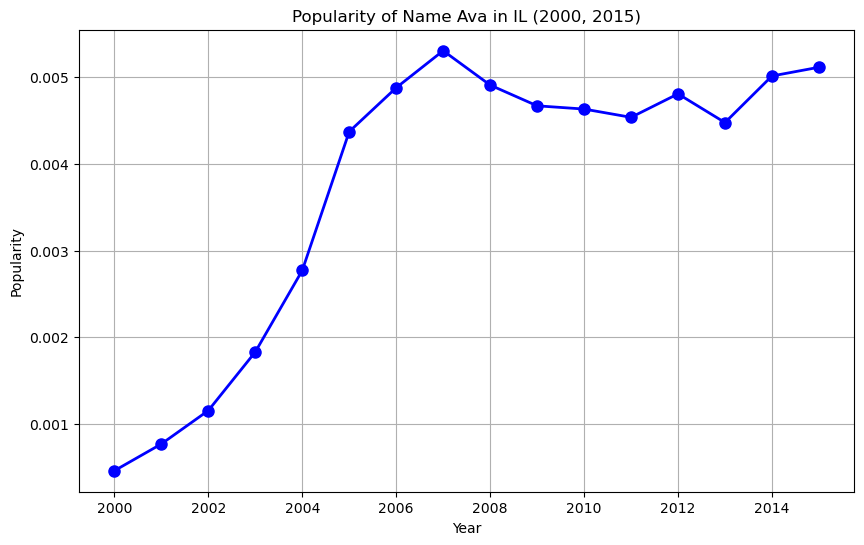

In [21]:
b.name_popuarity_plot(name = name, yearRange = yearRange, state = state, sex = sex)

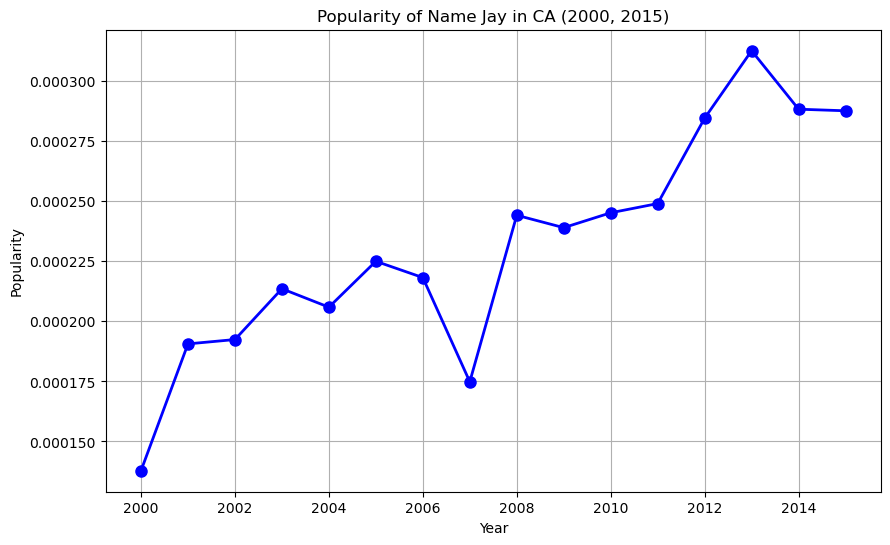

In [22]:
name = 'Jay'
yearRange=(2000,2015)
state='CA'
sex='M'
b.name_popuarity_plot(name=name, yearRange=yearRange, state=state, sex=sex)

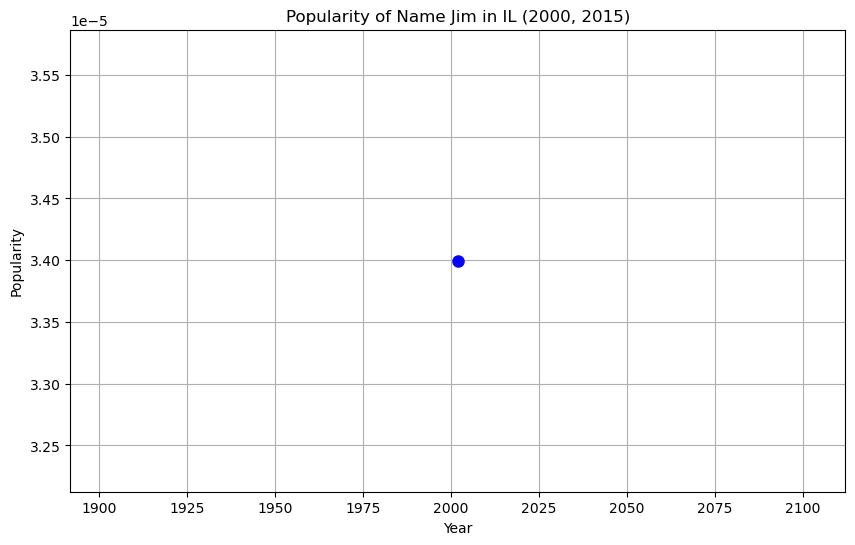

In [23]:
name = 'Jim'
yearRange=(2000,2015)
state='IL'
sex='M'
b.name_popuarity_plot(name=name, yearRange=yearRange, state=state, sex=sex)

### g. NameFlip(n=10):
List top n names that flipped over the years.(i.e.from boy name to girl or the reverse). Provide a plot of the names showing the year.


In [24]:
n = 10

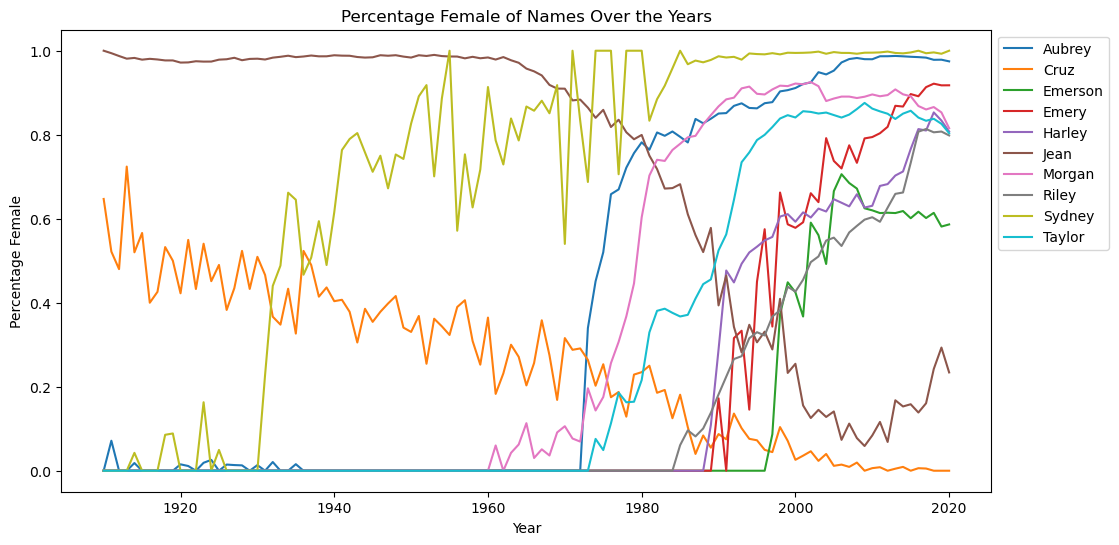

In [25]:
b.name_flip(n)

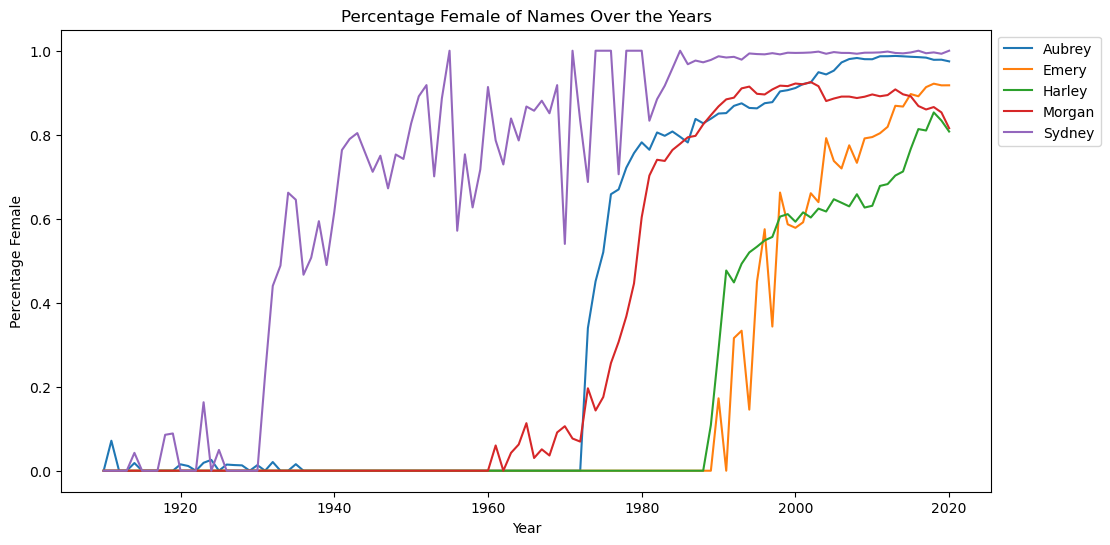

In [26]:
n = 5
b.name_flip(n)

### Percent of male and female babies born over years

We can see that there were much more female babies in the first few years of the dataset, then percentage of male babies gradually increased and stayed more than female babies. It is true that the 'natural' sex ratio at birth is around 105 boys per 100 girls, which corresponds to the later years in the dataset. The discrepancy in the first couple years may be due to data collection errors.

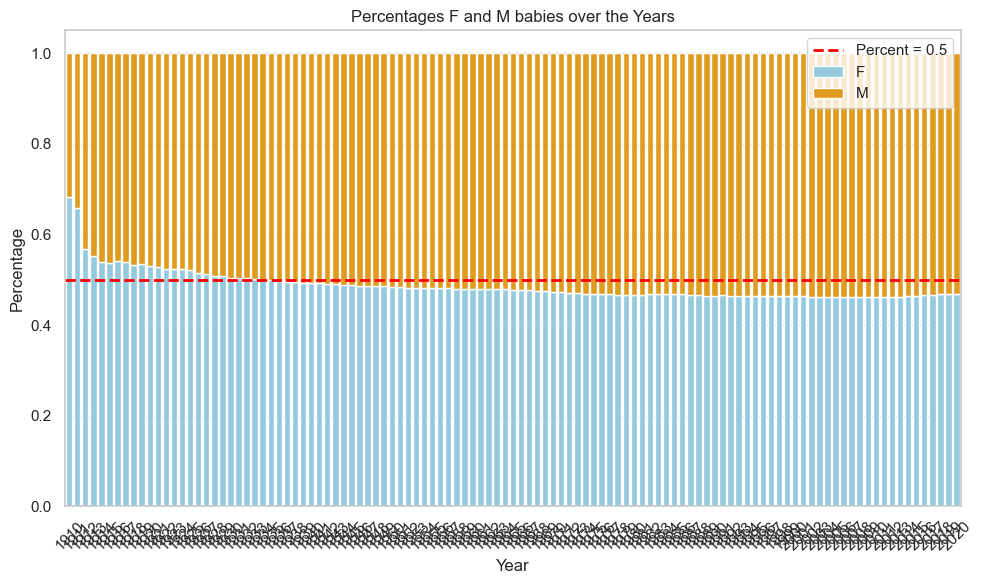

In [27]:
b.gender_trend()

# Exercise 2: Statistics & Data Visualization Practice
• The system tracks students by student name and unique ID.

• Grades are based on:
o Exams Score (40% of the final grade) 
o Projects Score (30% of the final grade) 
o Quizzes Score (30% of the final grade)

• Final Grades are based on the final score (out of 100) as follows: 

[90-100]:  

[80-90): B 

[20-80): C

[10-20): D 

[0-10): F



### 1. Load the exams.csv file into a DataFrame.

In [28]:
exams = pd.read_csv("exams.csv")

In [29]:
weights = {'Exams': 0.4, 'Projects': 0.3, 'Quizzes': 0.3}
def calculate_grade(row):
    return row['Exams'] * weights['Exams'] + row['Projects'] * weights['Projects'] + row['Quizzes'] * weights['Quizzes']
# calculated the weighted grades
exams['Grades'] = exams.apply(calculate_grade, axis=1)

In [30]:
def final_grade(score):
    if 90 <= score <= 100:
        return 'A'
    elif 80 <= score < 90:
        return 'B'
    elif 20 <= score < 80:
        return 'C'
    elif 10 <= score < 20:
        return 'D'
    elif 0 <= score < 10:
        return 'F'
    else:
        return 'Invalid Score'  

# create a 'Final Grade' column
exams['Final Grade'] = exams['Grades'].apply(final_grade)
exams

,id,Name,Quizzes,Projects,Exams,Grades,Final Grade
0,ID1,James,43,51,55,50.2,C
1,ID2,Josephine,76,84,87,82.8,B
2,ID3,Art,89,94,92,91.7,A
3,ID4,Lenna,70,67,64,66.7,C
4,ID5,Donette,63,59,58,59.8,C
...,...,...,...,...,...,...,...
95,ID96,Carma,64,59,62,61.7,C
96,ID97,Malinda,66,62,55,60.4,C
97,ID98,Natalie,95,85,91,90.4,A
98,ID99,Lisha,69,67,55,62.8,C


### 2. Identify outlier students, or those who have final scores that are outside of the mean +/- two standard deviations of the final scores.

In [31]:
mean = exams['Grades'].mean()
std = exams['Grades'].std()
threshold = 2 * std

# Identify and filter the outlier students: mean +/- thereshold
outliers = exams[(exams['Grades'] < (mean - threshold)) | (exams['Grades'] > (mean + threshold))]

print(outliers)

      id      Name  Quizzes  Projects  Exams  Grades Final Grade
6    ID7    Mitsue       41        43     34    38.8           C
33  ID34    Albina       21        41     33    31.8           C
41  ID42      Dyan       99       100    100    99.7           A
45  ID46    Fatima       93       100    100    97.9           A
60  ID61  Blondell       37        28     32    32.3           C


### 3. Create boxplot parameters (not drawing them, but just computing the numbers, min, max, median, Q1 and Q3 for a box plot).

In [32]:
data = exams['Grades']
minimum = np.min(data)
maximum = np.max(data)
median = np.median(data)
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
print('minimum: ', minimum)
print('maximum: ', maximum)
print('median: ', median)
print('Q1: ', Q1)
print('Q3: ',Q3)

minimum:  31.8
maximum:  99.7
median:  68.65
Q1:  60.324999999999996
Q3:  80.25


### 4. Create a seaborn visualization that shows the final letter grades distribution. 
Choose the visualization that you think best represents the data. Explain your reasoning.

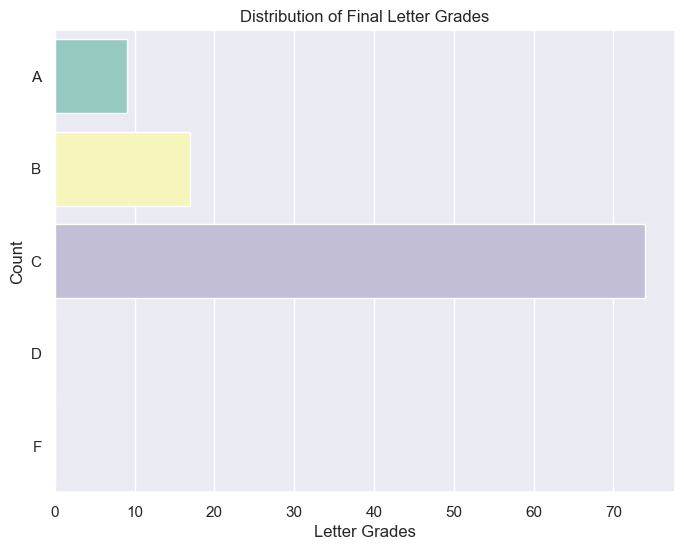

In [33]:
letter_grades = exams['Final Grade']
# Create a countplot
sns.set(style="darkgrid")
plt.figure(figsize=(8, 6))
sns.countplot(y=letter_grades, order=['A', 'B', 'C', 'D', 'F'], palette="Set3")

# Adding labels and a title
plt.xlabel("Letter Grades")
plt.ylabel("Count")
plt.title("Distribution of Final Letter Grades")
plt.show()

Letter grades are categorical data, and countplots and barplots are designed to show the distribution of categorical data effectively.

Countplots directly display the frequency (count) of each category (letter grade) in the dataset, providing a clear representation of the distribution.

The order parameter is used to arrange the x-axis categories ('A', 'B', 'C', 'D', 'F') in a specific order, which makes the plot more informative.

It provides a clear and straightforward representation of categorical data, making it easy to see how many students received each grade.


### 5. Discover two more insights from the data. 
Support your insights with calculations and/or seaborn plots.

In [34]:
# Performance Analysis
summary_statistics = exams[['Quizzes', 'Projects', 'Exams', 'Grades']].describe()
print(summary_statistics)

         Quizzes    Projects       Exams      Grades
count  100.00000  100.000000  100.000000  100.000000
mean    66.90000   70.810000   69.350000   69.053000
std     15.24646   14.571797   14.638661   14.199918
min     21.00000   28.000000   32.000000   31.800000
25%     58.00000   61.000000   60.250000   60.325000
50%     66.00000   71.000000   69.500000   68.650000
75%     76.50000   82.000000   78.250000   80.250000
max     99.00000  100.000000  100.000000   99.700000


These insights help us understand the distribution, central tendency, variability, and range of student performance in quizzes, projects, exams, and final grades. 

There are 100 data points for each of the Quizzes, Projects, Exams, and Grades, indicating that the dataset is complete with no missing values.

Mean:
The mean Quiz score is approximately 66.9, indicating that, on average, students scored around 66.9 on quizzes.
The mean Project score is approximately 70.81, indicating that, on average, students scored around 70.81 on projects.
The mean Exam score is approximately 69.35, indicating that, on average, students scored around 69.35 on exams.
The mean Grade is approximately 68.81, which is the average of student grades.

Standard Deviation:
The standard deviation for Quizzes (approximately 15.25), Projects (approximately 14.57), Exams (approximately 14.64), and Grades (approximately 14.21) indicates the spread or variability of the data.
A higher standard deviation suggests greater variability in student performance.

Minimum and Maximum:
The minimum Quiz score is 21, and the minimum Project score is 28, indicating that the lowest possible scores in these assessments.
The minimum Exam score is 32, and the minimum Grade is 30.6, indicating the lowest possible scores for exams and final grades.
The maximum Quiz score is 99, the maximum Project score is 100, and the maximum Exam score is 100, indicating the highest possible scores for these assessments.
The maximum Grade is 99.6, suggesting the highest possible final grade.



Text(0.5, 1.0, 'Distribution of Final Grades')

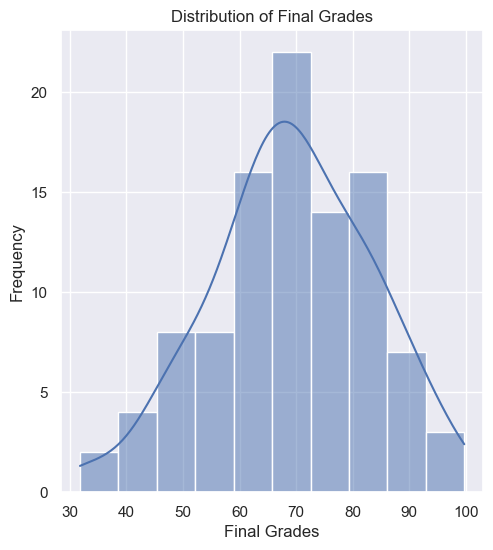

In [35]:
# Distribution of Grades
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(exams['Grades'], bins=10, kde=True)
plt.xlabel('Final Grades')

plt.ylabel('Frequency')
plt.title('Distribution of Final Grades')

The distribution of final grades are mainly focused on the range between 60 and 80, with few over 90 and few under 50. 

The central tendency, represented by the tallest peak, appears to be around the '70'. This suggests that a significant portion of students falls close to this grade range.

The distribution appears to be slightly right-skewed, as the tail of the histogram extends more to the right (toward higher grades) than to the left (toward lower grades). This suggests that there are more students with grades closer to the over 60-grade.

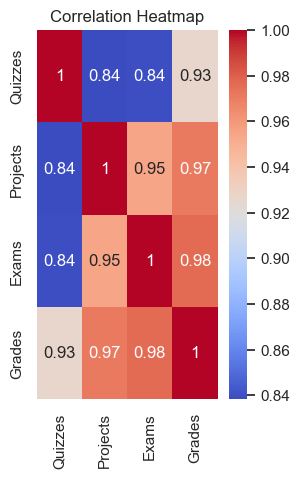

In [36]:
# Correlations
correlation_matrix = exams[['Quizzes', 'Projects', 'Exams', 'Grades']].corr()
plt.subplot(1, 2, 2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

plt.show()

We see that all Quizzes, Projects, Exams have strong correlation with Grades, which means they are all important in affecting the grades. Students should be aware of that and study all three parts. 